# A Candidate's tweets during the pandemic

### Computational Models of Human Behavior Project

##### Zordan Elena
_M.Sc. Data Science, University of Trento_


### Libraries 

In [82]:
import pandas as pd
import os
import numpy as np 
import sys
import nltk
import string
import datetime
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nrclex import NRCLex

import nltk.corpus
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from nltk import tokenize, sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet


from sklearn.model_selection import train_test_split # function for splitting data to train and test sets
from sklearn.feature_extraction.text import CountVectorizer


from nltk.classify import SklearnClassifier


# Exploratory Data Analysis

Some initial EDA in order to see how did the consensus and twitter activites of Joe Biden change over the years.

In [45]:
joe = pd.read_csv('JoeBidenTweets.csv')

In [46]:
joe.shape

(6064, 8)

6064 rows X 8 columns


Visualize the number of likes, retweets and replies per day

In [47]:
joe['timestamp'] = joe['timestamp'].apply(lambda x : datetime.datetime.strptime(x.split(" ")[0], "%Y-%m-%d"))
joe.head()

,id,timestamp,url,tweet,replies,retweets,quotes,likes
0,361388562,2007-10-24,https://twitter.com/JoeBiden/status/361388562,Tune in 11:30 ET tomorrow for a live webcast o...,19,5,17,11
1,543984392,2007-12-29,https://twitter.com/JoeBiden/status/543984392,"Iowans, there's a good chance there's a Biden ...",13,16,6,22
2,189287227321356289,2012-04-09,https://twitter.com/JoeBiden/status/1892872273...,We're excited to announce that @JoeBiden is be...,21,82,1,20
3,189287350034104320,2012-04-09,https://twitter.com/JoeBiden/status/1892873500...,Campaign staff will run this account to keep y...,144,76,37,51
4,189339650610036736,2012-04-09,https://twitter.com/JoeBiden/status/1893396506...,News for you this morning: VP Biden will speak...,10,54,0,5


In [23]:
joe_count = pd.DataFrame()

joe_count['replies'] = joe.groupby(['timestamp'])['replies'].sum()
joe_count['retweets'] = joe.groupby(['timestamp'])['retweets'].sum()
joe_count['quotes'] = joe.groupby(['timestamp'])['quotes'].sum()
joe_count['likes'] = joe.groupby(['timestamp'])['likes'].sum()
joe_final = joe_count.reset_index()
joe_final = joe_final.iloc[2:]
joe_final
 

,timestamp,replies,retweets,quotes,likes
2,2012-04-09,318,764,38,145
3,2012-04-10,71,308,1,152
4,2012-04-11,79,555,0,233
5,2012-04-12,43,143,0,29
6,2012-04-13,197,466,0,107
...,...,...,...,...,...
1081,2020-10-28,100590,207993,27088,1648256
1082,2020-10-29,95494,188689,27346,1412505
1083,2020-10-30,87215,206124,31551,1583683
1084,2020-10-31,105542,262108,39577,2058368


**Lineplot** (seaborn)

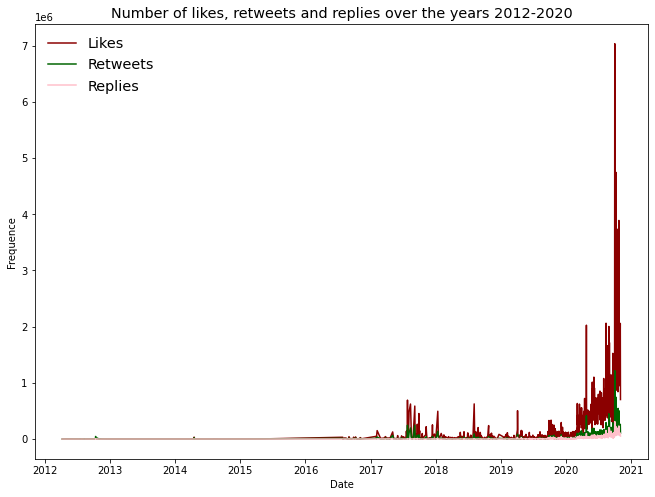

In [39]:
g_dims = (11, 8)

fig, ax = plt.subplots(figsize=g_dims)


sns.lineplot(data=joe_final, x="timestamp",y="likes", color="Darkred")
sns.lineplot(data=joe_final, x="timestamp",y="retweets", color="Darkgreen")
sns.lineplot(data=joe_final, x="timestamp",y="replies", color="pink")

plt.legend(labels=['Likes', 'Retweets', 'Replies'], loc='upper left', frameon=False, fontsize='x-large')

plt.xlabel("Date")
plt.ylabel("Frequence")


plt.title("Number of likes, retweets and replies over the years 2012-2020", fontsize='x-large')


plt.show()


Better visualise the last year (from December 2019 to November 2020)

In [37]:
joe_final_2020 = joe_final.iloc[747:]
joe_final_2020.head()

,timestamp,replies,retweets,quotes,likes
749,2019-12-01,5683,9199,954,65427
750,2019-12-02,3773,3546,560,19882
751,2019-12-03,5496,8158,942,70231
752,2019-12-04,2030,1975,272,10212
753,2019-12-05,46527,76499,20594,294290


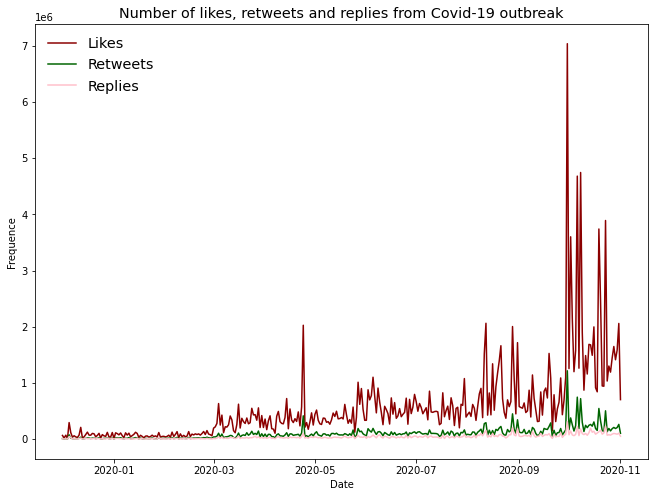

In [40]:
fig, ax = plt.subplots(figsize=g_dims)
g_dims = (13, 8)

sns.lineplot(data=joe_final_2020, x="timestamp",y="likes", color="Darkred")
sns.lineplot(data=joe_final_2020, x="timestamp",y="retweets", color="Darkgreen")
sns.lineplot(data=joe_final_2020, x="timestamp",y="replies", color="pink")

#UNCOMMENT TO SEE THE QUOTES 
#sns.lineplot(data=joe_final_2020, x="timestamp",y="quotes", color="blue")

plt.legend(labels=['Likes', 'Retweets', 'Replies'], loc='upper left', frameon=False, fontsize='x-large')

plt.xlabel("Date")
plt.ylabel("Frequence")


plt.title("Number of likes, retweets and replies from Covid-19 outbreak", fontsize='x-large')


plt.show()

As we can see, the number of likes increased exponentially over 2020, in particular since May 2020. 
Also the number of retweets increased, even though much less, but its trend is consistent with the ones of the likes.
With respect to the number of replies, there was a small growth from September 2020 onward. 
Number of quotes was not included since it reached quite low values. 

Code used to find out the **most liked** and **retweeted** tweets of Joe Biden.

The findings were added to the project proposal presentation 

In [55]:
most_liked_tweet = joe[joe.likes==max(df.likes)]
most_retweet_tweet = joe[joe.retweets==max(df.retweets)]

**Most liked tweet** (1,890,946 likes)

"Donald Trump is the worst president we've ever had"


**Most retweeted tweet** (326,070 rt)

"I can't believe I have to say this, but please don't drink bleach"

# Text preprocessing with NLTK

Select tweets created from December 2019 onward and create a new dataframe (df).

In [127]:
df = joe[joe.timestamp >= '2019-12-01'].reset_index(drop=True)

In [128]:
df

,id,timestamp,url,tweet,replies,retweets,quotes,likes
0,1200932522177122304,2019-12-01,https://twitter.com/JoeBiden/status/1200932522...,Eight years of Donald Trump will fundamentally...,4408,7287,787,53159
1,1201226459278385154,2019-12-01,https://twitter.com/JoeBiden/status/1201226459...,"Over the last 30 years, the fight against #HIV...",176,512,27,2148
2,1201255903498002432,2019-12-01,https://twitter.com/JoeBiden/status/1201255903...,Every voter counts. We need a president who is...,1099,1400,140,10120
3,1201296419987972096,2019-12-02,https://twitter.com/JoeBiden/status/1201296419...,Congressman and former Admiral @JoeSestak has ...,111,250,11,1654
4,1201303718391615493,2019-12-02,https://twitter.com/JoeBiden/status/1201303718...,We’re officially on the road for our eight-day...,1171,546,216,3232
...,...,...,...,...,...,...,...,...
3121,1322865972819251200,2020-11-01,https://twitter.com/JoeBiden/status/1322865972...,"As president, I’ll build an economy that rewar...",3085,3654,480,36995
3122,1322871257902145536,2020-11-01,https://twitter.com/JoeBiden/status/1322871257...,Let’s put dogs back in the White House. https:...,2211,4211,1246,34240
3123,1322876039144636417,2020-11-01,https://twitter.com/JoeBiden/status/1322876039...,We have in our hands the ultimate power: the p...,918,1143,122,6954
3124,1322881072363917312,2020-11-01,https://twitter.com/JoeBiden/status/1322881072...,"We need to:\n\nBuild bridges, not walls.\nOpen...",1281,2255,344,16696


In [129]:
#UNCOMMENT if needed: just once (the first time) in order to download all 

#nltk.download()

### Tokenization

In [130]:
df['tokenized'] = df['tweet'].apply(nltk.tokenize.WhitespaceTokenizer().tokenize)
df.head()

,id,timestamp,url,tweet,replies,retweets,quotes,likes,tokenized
0,1200932522177122304,2019-12-01,https://twitter.com/JoeBiden/status/1200932522...,Eight years of Donald Trump will fundamentally...,4408,7287,787,53159,"[Eight, years, of, Donald, Trump, will, fundam..."
1,1201226459278385154,2019-12-01,https://twitter.com/JoeBiden/status/1201226459...,"Over the last 30 years, the fight against #HIV...",176,512,27,2148,"[Over, the, last, 30, years,, the, fight, agai..."
2,1201255903498002432,2019-12-01,https://twitter.com/JoeBiden/status/1201255903...,Every voter counts. We need a president who is...,1099,1400,140,10120,"[Every, voter, counts., We, need, a, president..."
3,1201296419987972096,2019-12-02,https://twitter.com/JoeBiden/status/1201296419...,Congressman and former Admiral @JoeSestak has ...,111,250,11,1654,"[Congressman, and, former, Admiral, @JoeSestak..."
4,1201303718391615493,2019-12-02,https://twitter.com/JoeBiden/status/1201303718...,We’re officially on the road for our eight-day...,1171,546,216,3232,"[We’re, officially, on, the, road, for, our, e..."


In [131]:
df['tokenized'][0][:10] #shows only the first 10 elements of the first tweet

['Eight',
 'years',
 'of',
 'Donald',
 'Trump',
 'will',
 'fundamentally',
 'alter',
 'the',
 'character']

### Stopwords removal

In [133]:
stop_words = set(stopwords.words('english'))
df['stopwords_removed'] = df['tokenized'].apply(lambda x: [word for word in x if word not in stop_words])
df.head()

,id,timestamp,url,tweet,replies,retweets,quotes,likes,tokenized,stopwords_removed
0,1200932522177122304,2019-12-01,https://twitter.com/JoeBiden/status/1200932522...,Eight years of Donald Trump will fundamentally...,4408,7287,787,53159,"[Eight, years, of, Donald, Trump, will, fundam...","[Eight, years, Donald, Trump, fundamentally, a..."
1,1201226459278385154,2019-12-01,https://twitter.com/JoeBiden/status/1201226459...,"Over the last 30 years, the fight against #HIV...",176,512,27,2148,"[Over, the, last, 30, years,, the, fight, agai...","[Over, last, 30, years,, fight, #HIV, taught, ..."
2,1201255903498002432,2019-12-01,https://twitter.com/JoeBiden/status/1201255903...,Every voter counts. We need a president who is...,1099,1400,140,10120,"[Every, voter, counts., We, need, a, president...","[Every, voter, counts., We, need, president, r..."
3,1201296419987972096,2019-12-02,https://twitter.com/JoeBiden/status/1201296419...,Congressman and former Admiral @JoeSestak has ...,111,250,11,1654,"[Congressman, and, former, Admiral, @JoeSestak...","[Congressman, former, Admiral, @JoeSestak, ser..."
4,1201303718391615493,2019-12-02,https://twitter.com/JoeBiden/status/1201303718...,We’re officially on the road for our eight-day...,1171,546,216,3232,"[We’re, officially, on, the, road, for, our, e...","[We’re, officially, road, eight-day, #NoMalark..."


In [134]:
#create a string column containing texts
df['text_string'] = df['stopwords_removed'].apply(lambda x: ' '.join(x))

df['text_string'][0]


'Eight years Donald Trump fundamentally alter character nation. We cannot let happen. We must make one-term president.'

##### Most frequent words


In [154]:
# most frequent words

count = Counter()

for text in df['text_string'].values:
    for word in text.split():
        count[word] = count[word] + 1


        
count.most_common(10)


[('—', 1045),
 ('I', 1028),
 ('We', 728),
 ('Trump', 667),
 ('Donald', 617),
 ('need', 405),
 ('The', 368),
 ('get', 317),
 ('American', 316),
 ('make', 280)]

##### Removal of rare words

In [136]:
rare_word = 5

Rarewords = set([i for (i, ic) in count.most_common()[:-rare_word:-1]])

def del_rarewords(text):
    """
    function to remove the rare words
    """
    return " ".join([word for word in str(text).split() if word not in Rarewords])



df['text_string'] = df['text_string'].apply(lambda T: del_rarewords(T))


### Token Normalization

This operation reduces words to base form to be analyzed as a single term.

   * Stemming: A process of removing and replacing suffixes to get to the root form of the word, which is called stem.
   * Lemmatization: returns the base or dictionary form of a word.



##### Stemming

Comparison between Porter's and Snowball's stemming algorithms. 

In [137]:
words  = nltk.tokenize.WhitespaceTokenizer().tokenize(df["tweet"][100])
prova = pd.DataFrame()
prova['OriginalWords'] = pd.Series(words)
#porter's stemmer
porterStemmedWords = [nltk.stem.PorterStemmer().stem(word) for word in words]
prova['PorterStemmedWords'] = pd.Series(porterStemmedWords)
#SnowBall stemmer
snowballStemmedWords = [nltk.stem.SnowballStemmer("english").stem(word) for word in words]
prova['SnowballStemmedWords'] = pd.Series(snowballStemmedWords)
prova.head()

,OriginalWords,PorterStemmedWords,SnowballStemmedWords
0,The,the,the
1,Trump,trump,trump
2,Administration,administr,administr
3,is,is,is
4,recklessly,recklessli,reckless


In [138]:
ps = PorterStemmer()
df['stemmed'] = df['text_string'].apply(lambda x: ps.stem(x)) 

df.head()

,id,timestamp,url,tweet,replies,retweets,quotes,likes,tokenized,stopwords_removed,text_string,stemmed
0,1200932522177122304,2019-12-01,https://twitter.com/JoeBiden/status/1200932522...,Eight years of Donald Trump will fundamentally...,4408,7287,787,53159,"[Eight, years, of, Donald, Trump, will, fundam...","[Eight, years, Donald, Trump, fundamentally, a...",Eight years Donald Trump fundamentally alter c...,eight years donald trump fundamentally alter c...
1,1201226459278385154,2019-12-01,https://twitter.com/JoeBiden/status/1201226459...,"Over the last 30 years, the fight against #HIV...",176,512,27,2148,"[Over, the, last, 30, years,, the, fight, agai...","[Over, last, 30, years,, fight, #HIV, taught, ...","Over last 30 years, fight #HIV taught us big-h...","over last 30 years, fight #hiv taught us big-h..."
2,1201255903498002432,2019-12-01,https://twitter.com/JoeBiden/status/1201255903...,Every voter counts. We need a president who is...,1099,1400,140,10120,"[Every, voter, counts., We, need, a, president...","[Every, voter, counts., We, need, president, r...",Every voter counts. We need president ready li...,every voter counts. we need president ready li...
3,1201296419987972096,2019-12-02,https://twitter.com/JoeBiden/status/1201296419...,Congressman and former Admiral @JoeSestak has ...,111,250,11,1654,"[Congressman, and, former, Admiral, @JoeSestak...","[Congressman, former, Admiral, @JoeSestak, ser...",Congressman former Admiral @JoeSestak served c...,congressman former admiral @joesestak served c...
4,1201303718391615493,2019-12-02,https://twitter.com/JoeBiden/status/1201303718...,We’re officially on the road for our eight-day...,1171,546,216,3232,"[We’re, officially, on, the, road, for, our, e...","[We’re, officially, road, eight-day, #NoMalark...",We’re officially road eight-day #NoMalarkey To...,we’re officially road eight-day #nomalarkey to...


#### Lemmatization
turn the words to base form 

In [139]:
lemmatizer = WordNetLemmatizer()
wordnet_m = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}


def lemmat_pos_word(text):
    
    pos_tagger_text = nltk.pos_tag(text.split())
    
    return " ".join([lemmatizer.lemmatize(word, wordnet_m.get(pos[0],wordnet.NOUN)) for word,pos in pos_tagger_text])



df['lemmatization'] = df['text_string'].apply(lambda T : lemmat_pos_word(T))

df.head()


,id,timestamp,url,tweet,replies,retweets,quotes,likes,tokenized,stopwords_removed,text_string,stemmed,lemmatization
0,1200932522177122304,2019-12-01,https://twitter.com/JoeBiden/status/1200932522...,Eight years of Donald Trump will fundamentally...,4408,7287,787,53159,"[Eight, years, of, Donald, Trump, will, fundam...","[Eight, years, Donald, Trump, fundamentally, a...",Eight years Donald Trump fundamentally alter c...,eight years donald trump fundamentally alter c...,Eight year Donald Trump fundamentally alter ch...
1,1201226459278385154,2019-12-01,https://twitter.com/JoeBiden/status/1201226459...,"Over the last 30 years, the fight against #HIV...",176,512,27,2148,"[Over, the, last, 30, years,, the, fight, agai...","[Over, last, 30, years,, fight, #HIV, taught, ...","Over last 30 years, fight #HIV taught us big-h...","over last 30 years, fight #hiv taught us big-h...","Over last 30 years, fight #HIV teach u big-hea..."
2,1201255903498002432,2019-12-01,https://twitter.com/JoeBiden/status/1201255903...,Every voter counts. We need a president who is...,1099,1400,140,10120,"[Every, voter, counts., We, need, a, president...","[Every, voter, counts., We, need, president, r...",Every voter counts. We need president ready li...,every voter counts. we need president ready li...,Every voter counts. We need president ready li...
3,1201296419987972096,2019-12-02,https://twitter.com/JoeBiden/status/1201296419...,Congressman and former Admiral @JoeSestak has ...,111,250,11,1654,"[Congressman, and, former, Admiral, @JoeSestak...","[Congressman, former, Admiral, @JoeSestak, ser...",Congressman former Admiral @JoeSestak served c...,congressman former admiral @joesestak served c...,Congressman former Admiral @JoeSestak serve co...
4,1201303718391615493,2019-12-02,https://twitter.com/JoeBiden/status/1201303718...,We’re officially on the road for our eight-day...,1171,546,216,3232,"[We’re, officially, on, the, road, for, our, e...","[We’re, officially, road, eight-day, #NoMalark...",We’re officially road eight-day #NoMalarkey To...,we’re officially road eight-day #nomalarkey to...,We’re officially road eight-day #NoMalarkey To...


### P.O.S. tagging

Part-of-speech tagging marks words in the corpus to a corresponding part of speech tag based on its context and definition.

Hence, it allows to determine the part of speech (ie. noun, verb, adverb, etc.) for each word.

POS tags are useful for lemmatization and extracting relationships between words.

In [140]:
df['pos_tags'] = df['stopwords_removed'].apply(nltk.tag.pos_tag)
df.head()

,id,timestamp,url,tweet,replies,retweets,quotes,likes,tokenized,stopwords_removed,text_string,stemmed,lemmatization,pos_tags
0,1200932522177122304,2019-12-01,https://twitter.com/JoeBiden/status/1200932522...,Eight years of Donald Trump will fundamentally...,4408,7287,787,53159,"[Eight, years, of, Donald, Trump, will, fundam...","[Eight, years, Donald, Trump, fundamentally, a...",Eight years Donald Trump fundamentally alter c...,eight years donald trump fundamentally alter c...,Eight year Donald Trump fundamentally alter ch...,"[(Eight, CD), (years, NNS), (Donald, NNP), (Tr..."
1,1201226459278385154,2019-12-01,https://twitter.com/JoeBiden/status/1201226459...,"Over the last 30 years, the fight against #HIV...",176,512,27,2148,"[Over, the, last, 30, years,, the, fight, agai...","[Over, last, 30, years,, fight, #HIV, taught, ...","Over last 30 years, fight #HIV taught us big-h...","over last 30 years, fight #hiv taught us big-h...","Over last 30 years, fight #HIV teach u big-hea...","[(Over, IN), (last, JJ), (30, CD), (years,, JJ..."
2,1201255903498002432,2019-12-01,https://twitter.com/JoeBiden/status/1201255903...,Every voter counts. We need a president who is...,1099,1400,140,10120,"[Every, voter, counts., We, need, a, president...","[Every, voter, counts., We, need, president, r...",Every voter counts. We need president ready li...,every voter counts. we need president ready li...,Every voter counts. We need president ready li...,"[(Every, DT), (voter, NN), (counts., NN), (We,..."
3,1201296419987972096,2019-12-02,https://twitter.com/JoeBiden/status/1201296419...,Congressman and former Admiral @JoeSestak has ...,111,250,11,1654,"[Congressman, and, former, Admiral, @JoeSestak...","[Congressman, former, Admiral, @JoeSestak, ser...",Congressman former Admiral @JoeSestak served c...,congressman former admiral @joesestak served c...,Congressman former Admiral @JoeSestak serve co...,"[(Congressman, NNP), (former, JJ), (Admiral, N..."
4,1201303718391615493,2019-12-02,https://twitter.com/JoeBiden/status/1201303718...,We’re officially on the road for our eight-day...,1171,546,216,3232,"[We’re, officially, on, the, road, for, our, e...","[We’re, officially, road, eight-day, #NoMalark...",We’re officially road eight-day #NoMalarkey To...,we’re officially road eight-day #nomalarkey to...,We’re officially road eight-day #NoMalarkey To...,"[(We’re, NNP), (officially, RB), (road, NN), (..."


**NLTK’s word lemmatizer** needs the parts of speech tags to be converted to wordnet’s format. 

Write a function which make the proper conversion and then use the function within a list comprehension to apply the conversion. 
Finally, apply NLTK’s word lemmatizer.

In [141]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
df['wordnet_pos'] = df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
df.head() 


,id,timestamp,url,tweet,replies,retweets,quotes,likes,tokenized,stopwords_removed,text_string,stemmed,lemmatization,pos_tags,wordnet_pos
0,1200932522177122304,2019-12-01,https://twitter.com/JoeBiden/status/1200932522...,Eight years of Donald Trump will fundamentally...,4408,7287,787,53159,"[Eight, years, of, Donald, Trump, will, fundam...","[Eight, years, Donald, Trump, fundamentally, a...",Eight years Donald Trump fundamentally alter c...,eight years donald trump fundamentally alter c...,Eight year Donald Trump fundamentally alter ch...,"[(Eight, CD), (years, NNS), (Donald, NNP), (Tr...","[(Eight, n), (years, n), (Donald, n), (Trump, ..."
1,1201226459278385154,2019-12-01,https://twitter.com/JoeBiden/status/1201226459...,"Over the last 30 years, the fight against #HIV...",176,512,27,2148,"[Over, the, last, 30, years,, the, fight, agai...","[Over, last, 30, years,, fight, #HIV, taught, ...","Over last 30 years, fight #HIV taught us big-h...","over last 30 years, fight #hiv taught us big-h...","Over last 30 years, fight #HIV teach u big-hea...","[(Over, IN), (last, JJ), (30, CD), (years,, JJ...","[(Over, n), (last, a), (30, n), (years,, a), (..."
2,1201255903498002432,2019-12-01,https://twitter.com/JoeBiden/status/1201255903...,Every voter counts. We need a president who is...,1099,1400,140,10120,"[Every, voter, counts., We, need, a, president...","[Every, voter, counts., We, need, president, r...",Every voter counts. We need president ready li...,every voter counts. we need president ready li...,Every voter counts. We need president ready li...,"[(Every, DT), (voter, NN), (counts., NN), (We,...","[(Every, n), (voter, n), (counts., n), (We, n)..."
3,1201296419987972096,2019-12-02,https://twitter.com/JoeBiden/status/1201296419...,Congressman and former Admiral @JoeSestak has ...,111,250,11,1654,"[Congressman, and, former, Admiral, @JoeSestak...","[Congressman, former, Admiral, @JoeSestak, ser...",Congressman former Admiral @JoeSestak served c...,congressman former admiral @joesestak served c...,Congressman former Admiral @JoeSestak serve co...,"[(Congressman, NNP), (former, JJ), (Admiral, N...","[(Congressman, n), (former, a), (Admiral, n), ..."
4,1201303718391615493,2019-12-02,https://twitter.com/JoeBiden/status/1201303718...,We’re officially on the road for our eight-day...,1171,546,216,3232,"[We’re, officially, on, the, road, for, our, e...","[We’re, officially, road, eight-day, #NoMalark...",We’re officially road eight-day #NoMalarkey To...,we’re officially road eight-day #nomalarkey to...,We’re officially road eight-day #NoMalarkey To...,"[(We’re, NNP), (officially, RB), (road, NN), (...","[(We’re, n), (officially, r), (road, n), (eigh..."


### Information retrieval
_Named Entity Recognition_ (NER)

NER seeks to extract a real-world entity from the text and sorts into predefined categories such as names of people, organizations, locations and so on. 

In [142]:
df['ne_chunked'] = df['pos_tags'].apply(nltk.ne_chunk)

In [143]:
named_entities = []

for tagged_tree in df['ne_chunked']: 
    if hasattr(tagged_tree, 'label'):
        entity_name = " ".join(c[0] for c in tagged_tree.leaves())
        entity_type = tagged_tree.label()
        named_entities.append((entity_name, entity_type))
        

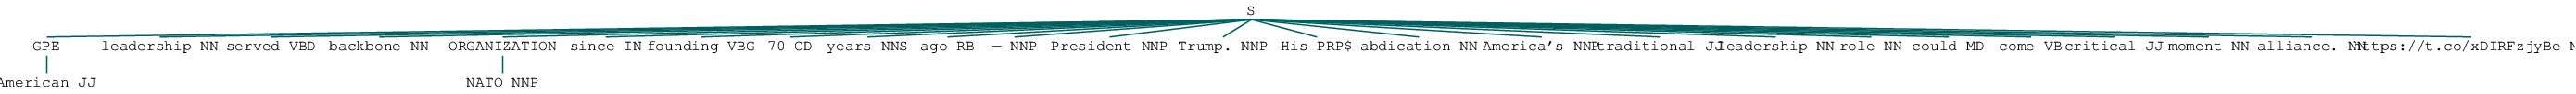

In [152]:
df.ne_chunked[6]

In [153]:
df.ne_chunked[6][:]

[Tree('GPE', [('American', 'JJ')]),
 ('leadership', 'NN'),
 ('served', 'VBD'),
 ('backbone', 'NN'),
 Tree('ORGANIZATION', [('NATO', 'NNP')]),
 ('since', 'IN'),
 ('founding', 'VBG'),
 ('70', 'CD'),
 ('years', 'NNS'),
 ('ago', 'RB'),
 ('—', 'NNP'),
 ('President', 'NNP'),
 ('Trump.', 'NNP'),
 ('His', 'PRP$'),
 ('abdication', 'NN'),
 ('America’s', 'NNP'),
 ('traditional', 'JJ'),
 ('leadership', 'NN'),
 ('role', 'NN'),
 ('could', 'MD'),
 ('come', 'VB'),
 ('critical', 'JJ'),
 ('moment', 'NN'),
 ('alliance.', 'NN'),
 ('https://t.co/xDIRFzjyBe', 'NN')]

# Sentiment Analysis

In [70]:
! ls

01-Computational Social Science and the Study of Political Communication.pdf
02-inference_personalattr.pdf
03-Uyheng-Carley2020_Article_BotsAndOnlineHateDuringTheCOVI.pdf
04-clinton_trump_2016.pdf
CMHB presentation.pptx
Final Paper.docx
JoeBidenTweets.csv
NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt
Project.ipynb
ppt
prova.R
provapy.ipynb
str.pages


### NRClex

In [20]:
filepath = "NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=45, sep='\t')
emolex_df.head(12)

,word,emotion,association
0,abandonment,negative,1
1,abandonment,positive,0
2,abandonment,sadness,1
3,abandonment,surprise,1
4,abandonment,trust,0
5,abate,anger,0
6,abate,anticipation,0
7,abate,disgust,0
8,abate,fear,0
9,abate,joy,0


In [78]:
# what emotions are covered and count values for each 
emolex_df.emotion.unique()
emolex_df.emotion.value_counts()

negative        14178
trust           14178
sadness         14178
surprise        14178
positive        14178
anticipation    14177
joy             14177
anger           14177
disgust         14177
fear            14177
Name: emotion, dtype: int64

In [79]:
# how many words each emotions has
emolex_df[emolex_df.association == 1].emotion.value_counts()

negative        3322
positive        2312
fear            1473
anger           1245
trust           1230
sadness         1189
disgust         1058
anticipation     839
joy              689
surprise         534
Name: emotion, dtype: int64

In [21]:
sid = SentimentIntensityAnalyzer()

In [22]:
df['scores'] = df['lemma_text'].apply(lambda review: sid.polarity_scores(review))

df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])

df['Negative']  = df['scores'].apply(lambda score_dict: score_dict['neg'])

df['Neutral']  = df['scores'].apply(lambda score_dict: score_dict['neu'])

df['Positive']  = df['scores'].apply(lambda score_dict: score_dict['pos'])




df['number_of_words'] = df['text_string'].str.split().apply(lambda x: len(x))


df.head()

,index,id,timestamp,url,tweet,replies,retweets,quotes,likes,date_simpl,...,text_string,lemma_text,pos_tags,wordnet_pos,scores,compound,Negative,Neutral,Positive,number_of_words
0,2938,1200932522177122304,2019-12-01 00:20,https://twitter.com/JoeBiden/status/1200932522...,Eight years of Donald Trump will fundamentally...,4408,7287,787,53159,2019-12-01 00:20,...,eight years donald trump fundamentally alter c...,eight year donald trump fundamentally alter ch...,"[(eight, CD), (years, NNS), (donald, RB), (tru...","[(eight, n), (years, n), (donald, r), (trump, ...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,1.000,0.000,15
1,2939,1201226459278385154,2019-12-01 19:48,https://twitter.com/JoeBiden/status/1201226459...,"Over the last 30 years, the fight against #HIV...",176,512,27,2148,2019-12-01 19:48,...,"last 30 years, fight #hiv taught us big-hearte...","last 30 years, fight #hiv teach u big-hearted;...","[(last, JJ), (30, CD), (years,, JJ), (fight, N...","[(last, a), (30, n), (years,, a), (fight, n), ...","{'neg': 0.091, 'neu': 0.523, 'pos': 0.387, 'co...",0.8176,0.091,0.523,0.387,21
2,2940,1201255903498002432,2019-12-01 21:45,https://twitter.com/JoeBiden/status/1201255903...,Every voter counts. We need a president who is...,1099,1400,140,10120,2019-12-01 21:45,...,every voter counts. need president ready liste...,every voter counts. need president ready liste...,"[(every, DT), (voter, NN), (counts., VBP), (ne...","[(every, n), (voter, n), (counts., v), (need, ...","{'neg': 0.0, 'neu': 0.783, 'pos': 0.217, 'comp...",0.3612,0.000,0.783,0.217,10
3,2941,1201296419987972096,2019-12-02 00:26,https://twitter.com/JoeBiden/status/1201296419...,Congressman and former Admiral @JoeSestak has ...,111,250,11,1654,2019-12-02 00:26,...,congressman former admiral @joesestak served c...,congressman former admiral @joesestak serve co...,"[(congressman, NN), (former, JJ), (admiral, JJ...","[(congressman, n), (former, a), (admiral, a), ...","{'neg': 0.0, 'neu': 0.474, 'pos': 0.526, 'comp...",0.9246,0.000,0.474,0.526,18
4,2942,1201303718391615493,2019-12-02 00:55,https://twitter.com/JoeBiden/status/1201303718...,We’re officially on the road for our eight-day...,1171,546,216,3232,2019-12-02 00:55,...,we’re officially road eight-day #nomalarkey to...,we’re officially road eight-day #nomalarkey to...,"[(we’re, NN), (officially, RB), (road, NN), (e...","[(we’re, n), (officially, r), (road, n), (eigh...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,1.000,0.000,9


#### N-gram analysis function

In [23]:
def text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]



## Some Data Visualisation

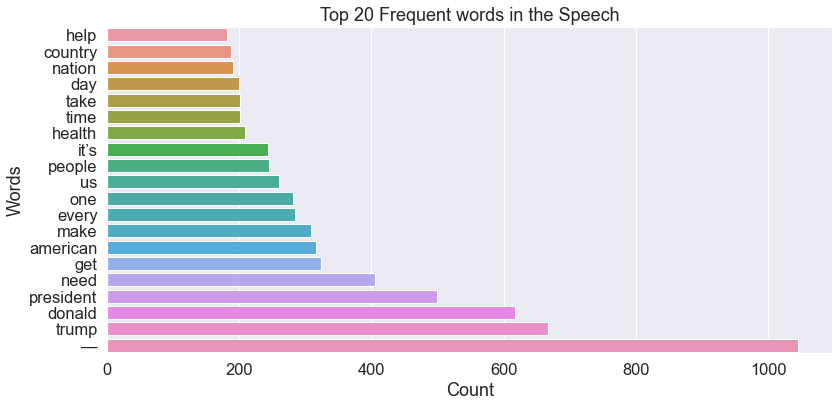

In [24]:


freq_word = count.most_common(20)

freq_word_plot1 = pd.Series( (v[0] for v in freq_word) )
freq_word_plot2 = pd.Series( (v[1] for v in freq_word) )


data_freq = pd.DataFrame({'Words':freq_word_plot1,'Count':freq_word_plot2})
data_freq = data_freq.sort_values('Count')


#plot
plt.figure(figsize = (12,6))
sns.set_style('darkgrid')
sns.set_context(context='notebook',font_scale=1.5)
sns.barplot(data=data_freq,y='Words',x='Count');
plt.title('Top 20 Frequent words in the Speech');
plt.tight_layout();



_Wordcloud_

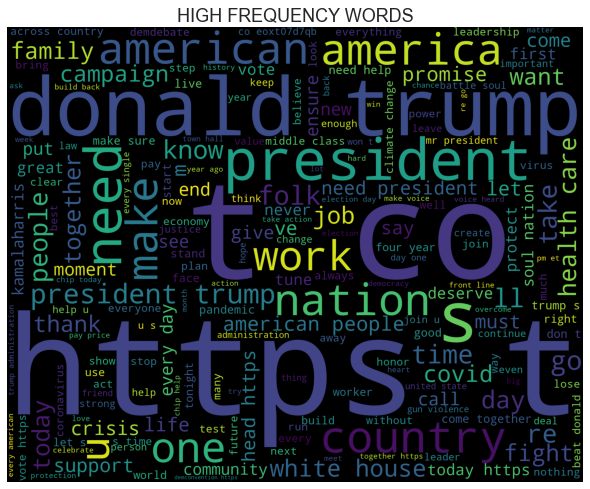

In [26]:
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df['lemma_text']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wc = WordCloud(width = 1900, height = 1500, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

#wordcloud.recolor(color_func = grey_color_func)

default_colors = wc.to_array()
#plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),interpolation="bilinear")
  

 #plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = '#FFFFFF') 
plt.imshow(wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('HIGH FREQUENCY WORDS')  
plt.show() 

#### Unigram 

Text(0.5, 1.0, 'Unigram Analysis')

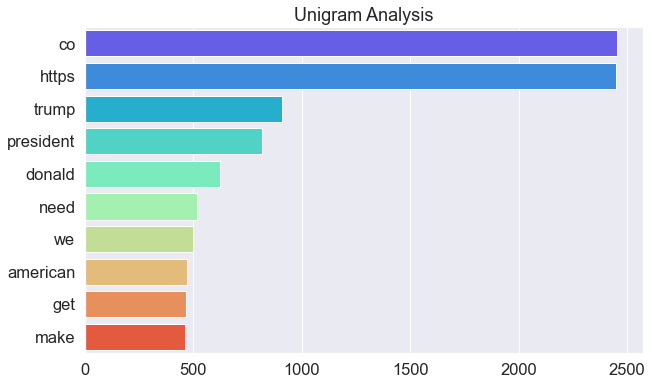

In [42]:
plt.figure(figsize = (10,6))
sns.set_style('darkgrid')
sns.set_context(context='notebook',font_scale=1.5)
Unigram_word = text_ngrams(df.lemma_text,10,1)
Unigram_word = dict(Unigram_word)
sns.barplot(x=list(Unigram_word.values()),y=list(Unigram_word.keys()),palette = 'rainbow')
plt.title('Unigram Analysis')

Text(0.5, 1.0, 'Unigram Analysis')

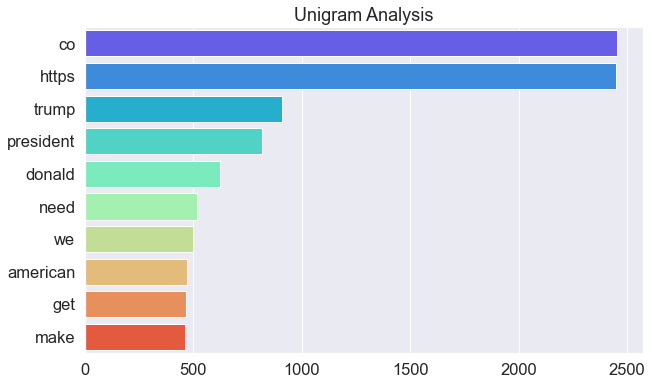

In [27]:
plt.figure(figsize = (10,6))
sns.set_style('darkgrid')
sns.set_context(context='notebook',font_scale=1.5)
Unigram_word = text_ngrams(df.lemma_text,10,1)
Unigram_word = dict(Unigram_word)
sns.barplot(x=list(Unigram_word.values()),y=list(Unigram_word.keys()),palette = 'rainbow')
plt.title('Unigram Analysis')


#### Bigram

Text(0.5, 1.0, 'bigram Analysis')

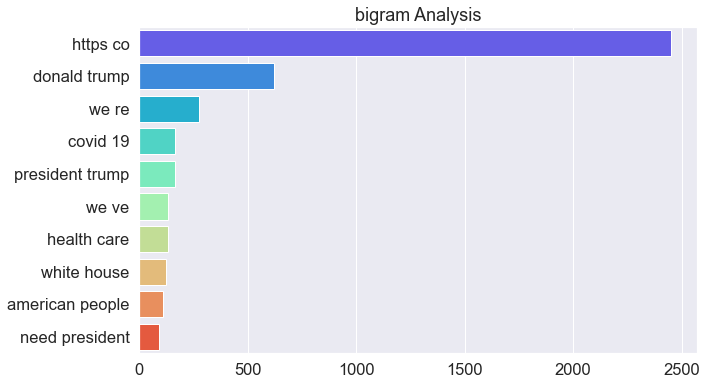

In [28]:
plt.figure(figsize = (10,6))
sns.set_style('darkgrid')
sns.set_context(context='notebook',font_scale=1.5)
Unigram_word = text_ngrams(df.lemma_text,10,2)
Unigram_word = dict(Unigram_word)
sns.barplot(x=list(Unigram_word.values()),y=list(Unigram_word.keys()),palette = 'rainbow')
plt.title('bigram Analysis')

#### Trigram

Text(0.5, 1.0, 'Trigram Analysis')

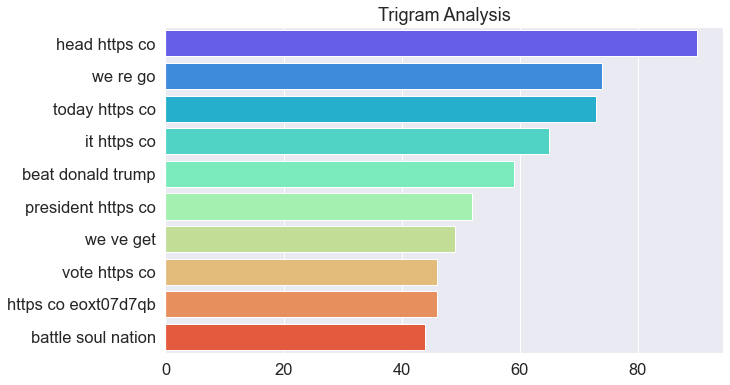

In [29]:
plt.figure(figsize = (10,6))
sns.set_style('darkgrid')
sns.set_context(context='notebook',font_scale=1.5)
Unigram_word = text_ngrams(df.lemma_text,10,3)
Unigram_word = dict(Unigram_word)
sns.barplot(x=list(Unigram_word.values()),y=list(Unigram_word.keys()),palette = 'rainbow')
plt.title('Trigram Analysis')

## Sentiment Analysis

In [31]:
# data for plot
df_sen = df[['Negative','Neutral', 'Positive']]
df_sen_avg = df_sen.mean().reset_index()
df_sen_avg.columns = ['sentiments','score']



##### Plot 

Text(0.5, 1.0, 'Sentiments in Tweets')

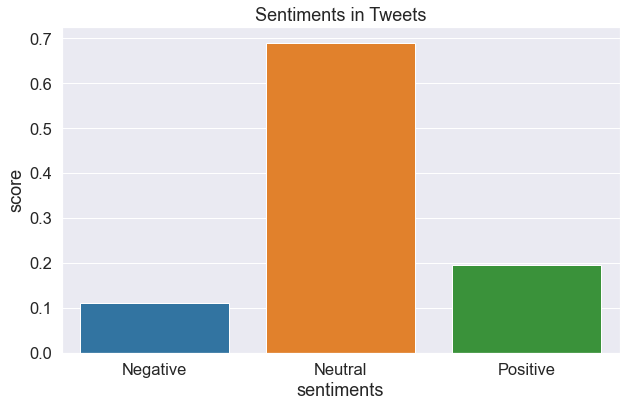

In [32]:
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
sns.set_context(context='notebook',font_scale=1.5)
sns.barplot(y='score', x='sentiments', data=df_sen_avg)
plt.title('Sentiments in Tweets')

### NRClex

Sentiment dictionary that measures emotional affects (fear, anger, anticipation, trust, surprise, positive, negative, sadness, disgust, joy)

In [33]:
def Review_emo(word):
    """
    Function to convert the raw data to utf-8 formate
    
    * convert to data Frame
    
    """
    
    word = str([cell.encode('utf-8') for cell in word])# to convert the text into utf-8 unicode
    str_text = NRCLex(word) 
    str_text = str_text.raw_emotion_scores
    str_text = pd.DataFrame(str_text,index=[0])
    str_text = pd.melt(str_text)
    str_text.columns = ('Emotions','Count')
    str_text = str_text.sort_values('Count')
    
    return str_text


rating_clean = Review_emo(df['lemma_text'])


##### Plot

Text(0.5, 1.0, "Emotional affects in Biden's Tweets")

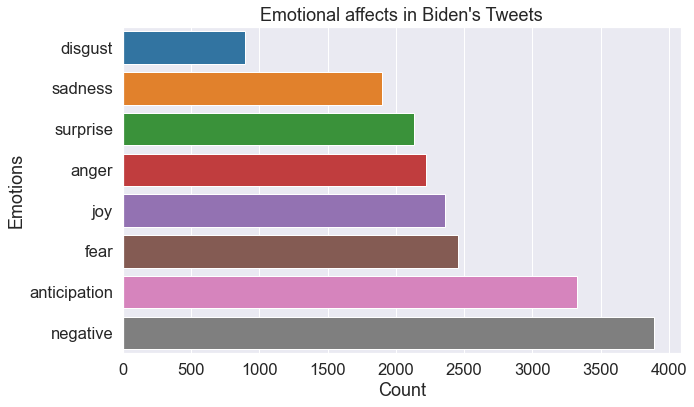

In [34]:
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
sns.set_context(context='notebook',font_scale=1.5)
sns.barplot(y='Emotions',x='Count',data=rating_clean[0:8],)
plt.title("Emotional affects in Biden's Tweets")